# Stochastic Signal Detection (SSD)

In what follows, we simulate the behaviour of the RG of the stochastic field theory around the Marchenko–Pastur (MP) distribution.

In [101]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
from pathlib import Path

import numpy as np
from IPython.display import Video
from matplotlib import pyplot as plt
from pde import CartesianGrid, MemoryStorage, ScalarField
from pde.visualization.movies import movie
from scipy import stats

plt.style.use('ggplot')
output_dir = Path('sim_empirical')
output_dir.mkdir(exist_ok=True)

from ssd import SSD, InterpolateDistribution, TranslatedInverseMarchenkoPastur, MarchenkoPastur, HistogramDistribution, EmpiricalDistribution

## Functional Renormalization Group

We here simulate the behaviour of the functional RG.

In [103]:
# Parameters of the distribution
L = 0.8
sigma = 1.0
xlim_inf = 1.e-9
xlim_sup = 1.0
n_values = 1000
periodic = True
t_range = 100
dt = 1
k2 = 0.01
noise = 0.0
mu1 = 0.0
mu2 = -0.5
mu3 = 0.0
mu4 = 1.0
beta = 0.01
rank = 1500
viz_time = [0, t_range // 12, t_range // 6]


In [104]:
# Create the name of the output files
output_file = f'ssd_signal_L={L:.2f}_k2={k2:.2f}_mu1={mu1:.2f}_mu2={mu2:.2f}_mu3={mu3:.2f}_mu4={mu4:.2f}'

We then recreate an empirical distribution of singular values of Wishart matrices.

In [105]:
# Create the background noise
N = 5000
P = int(L * N)
Z = np.random.normal(0, 1, (N, P))

In [106]:
# Create a signal matrix
U = np.random.normal(0, 1, (N, rank))
V = np.random.normal(0, 1, (rank, P))
S = U @ V

In [107]:
# Create the full matrix
X = beta*S + Z

In [108]:
# Compute the covariance matrix
C = (X.T @ X) / N

# Invert the covariance matrix
C_inv = np.linalg.inv(C)

# Compute the eigenvalues
E = np.linalg.eigvalsh(C_inv)
EE = np.linalg.eigvalsh(C)
m = np.min(E)
E -= m

/tmp/ipykernel_44443/938325132.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


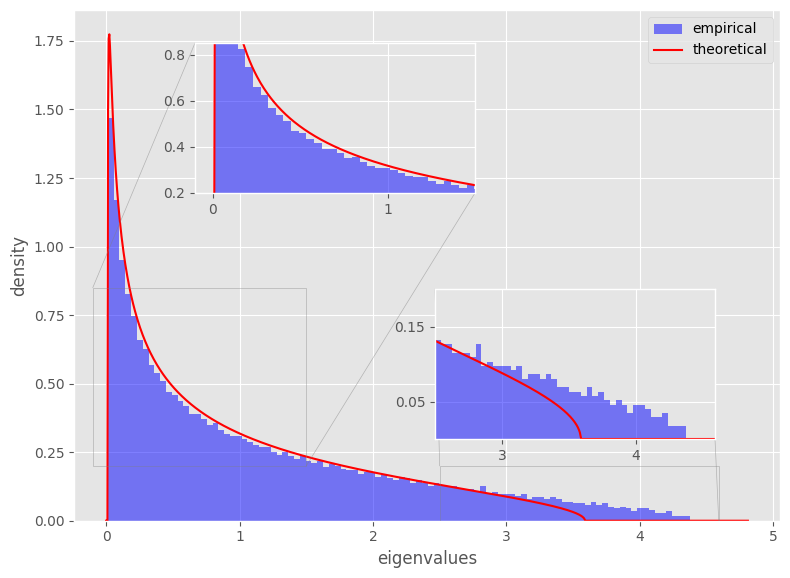

In [109]:
# Define the distribution
nbins = 100
# dist = InterpolateDistribution(nbins=nbins).fit(EE, n=2, s=0.01)
dist_th = MarchenkoPastur(L=L, sigma=sigma)

# Visualize the result
x = np.linspace(0, 1.1 * np.max(EE), 1000)
# y = np.array([dist(x_i) for x_i in x])
yy = np.array([dist_th(x_i) for x_i in x])
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(EE, bins=nbins, density=True, alpha=0.5, label='empirical', color='b')
# ax.plot(x, y, 'r-', label='interpolated')
ax.plot(x, yy, 'r-', label='theoretical')

ax.set_xlabel('eigenvalues')
ax.set_ylabel('density')

ax_inset_1 = fig.add_axes([0.55, 0.24, 0.35, 0.25])
ax_inset_1.set_xlim([2.5, 1.05 * np.max(EE)])
ax_inset_1.set_ylim([0.0, 0.2])
ax_inset_1.set_xticks([3, 4])
ax_inset_1.set_yticks([0.05, 0.15])
ax_inset_1.hist(EE,
                bins=nbins,
                density=True,
                alpha=0.5,
                label='empirical',
                color='b')
# ax_inset_1.plot(x, y, 'r-', label='interpolated')
ax_inset_1.plot(x, yy, 'r-', label='theoretical')

ax_inset_2 = fig.add_axes([0.25, 0.65, 0.35, 0.25])
ax_inset_2.set_xlim([-0.1, 1.5])
ax_inset_2.set_ylim([0.2, 0.85])
ax_inset_2.set_xticks([0, 1])
ax_inset_2.set_yticks([0.2, 0.4, 0.6, 0.8])
ax_inset_2.hist(EE,
                bins=nbins,
                density=True,
                alpha=0.5,
                label='empirical',
                color='b')
# ax_inset_2.plot(x, y, 'r-', label='interpolated')
ax_inset_2.plot(x, yy, 'r-', label='theoretical')

ax.indicate_inset_zoom(ax_inset_1)
ax.indicate_inset_zoom(ax_inset_2)

ax.legend(loc='best')
fig.tight_layout()
fig.savefig(output_dir / f'interpolation_mp_{output_file}.pdf', dpi=300)
plt.show()
plt.close(fig)

/tmp/ipykernel_44443/1974657268.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


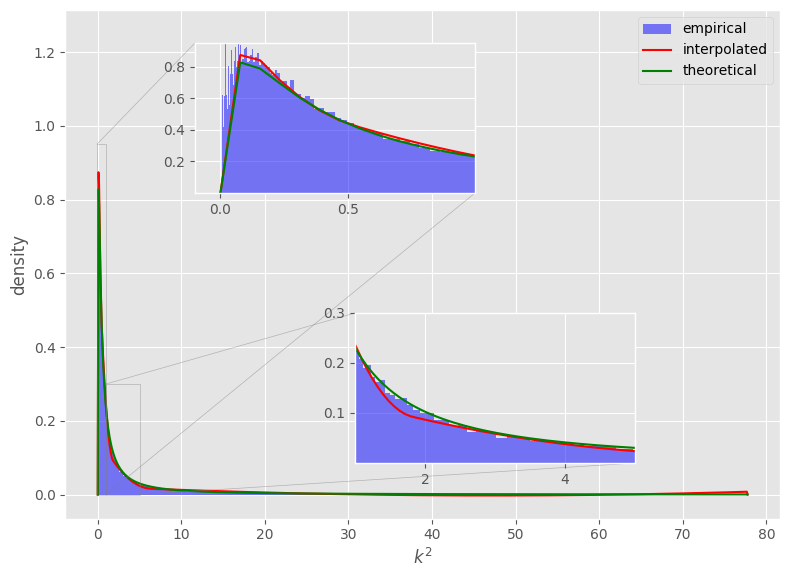

In [110]:
# Create exponentially distributed bins
p = np.linspace(0, 10, num=2*nbins + 1)
x = np.max(E) * np.exp(-p)
bins = x[::-1]

# Define the distribution
dist = InterpolateDistribution(bins=bins).fit(E, n=2, s=0.3)
dist_th = TranslatedInverseMarchenkoPastur(L=L, sigma=sigma)

# Visualize the result
x = np.linspace(0, np.max(E), 1000)
y = np.array([dist(x_i) for x_i in x])
yy = np.array([dist_th(x_i) for x_i in x])
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(E, bins=bins, density=True, alpha=0.5, label='empirical', color='b')
ax.plot(x, y, 'r-', label='interpolated')
ax.plot(x, yy, 'g-', label='theoretical')

ax.set_xlabel(r'$k^2$')
ax.set_ylabel('density')

ax_inset_1 = fig.add_axes([0.45, 0.2, 0.35, 0.25])
ax_inset_1.set_xlim([1, 5])
ax_inset_1.set_ylim([0.0, 0.3])
ax_inset_1.set_xticks([2, 4])
ax_inset_1.set_yticks([0.1, 0.2, 0.3])
ax_inset_1.hist(E,
                bins=bins,
                density=True,
                alpha=0.5,
                label='empirical',
                color='b')
ax_inset_1.plot(x, y, 'r-', label='interpolated')
ax_inset_1.plot(x, yy, 'g-', label='theoretical')

ax_inset_2 = fig.add_axes([0.25, 0.65, 0.35, 0.25])
ax_inset_2.set_xlim([-0.1, 1.0])
ax_inset_2.set_ylim([0.0, 0.95])
ax_inset_2.set_xticks([0, 0.5])
ax_inset_2.set_yticks([0.2, 0.4, 0.6, 0.8])
ax_inset_2.hist(E,
                bins=bins,
                density=True,
                alpha=0.5,
                label='empirical',
                color='b')
ax_inset_2.plot(x, y, 'r-', label='interpolated')
ax_inset_2.plot(x, yy, 'g-', label='theoretical')

ax.indicate_inset_zoom(ax_inset_1)
ax.indicate_inset_zoom(ax_inset_2)

ax.legend(loc='best')
fig.tight_layout()
fig.savefig(output_dir / f'interpolation_{output_file}.pdf', dpi=300)
plt.show()
plt.close(fig)

In [111]:
# Define the grid
grid = CartesianGrid(
    [[xlim_inf, xlim_sup]],
    [n_values],
    periodic=periodic,
)
expression = f'{mu1} + {mu2} * x + {mu3} * x**2 + {mu4} * x**3'
state = ScalarField.from_expression(grid, expression)
bc = 'periodic' if periodic else 'auto_periodic_neumann'

# Initialize a storage
storage = MemoryStorage()
trackers = [
    'progress',
    'steady_state',
    storage.tracker(interval=1),
]

# Define the PDE and solve
eq = SSD(dist=dist, k2=k2, noise=noise, bc=bc)
result = eq.solve(state, t_range=t_range, dt=dt, tracker=trackers)

movie(
    storage,
    output_dir / f'movie_{output_file}.mp4',
    show_time=True,
    movie_args={'framerate': 10},
    plot_args={
        'title': 'Stochastic Signal Detection',
        'ax_style': {
            'xlabel': r'$\chi$',
            'ylabel': r'$\overline{\mathcal{U}}^{~\prime}$',
        },
        'fig_style': {
            'dpi': 150,
        },
    },
)

# Remove the figure from buffer
fig = plt.gcf()
plt.close(fig)

  0%|          | 0/100.0 [00:00<?, ?it/s]              

/home/rf265700/Code/stochastic-signal-detection/ssd/base.py:61: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: x**moment * self(x), a, b)
  1%|          | 1.0/100.0 [00:00<00:10,  9.78it/s]/home/rf265700/Code/stochastic-signal-detection/ssd/base.py:61: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  pro

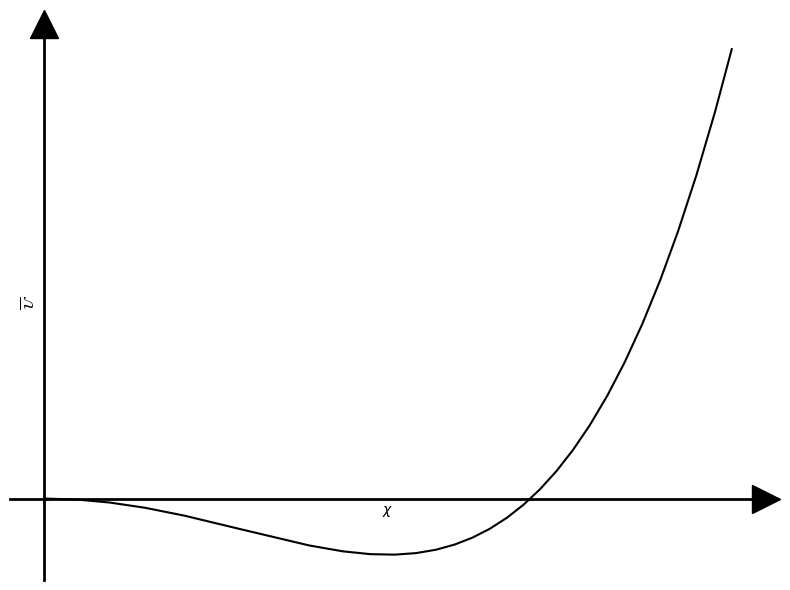

In [ ]:
# Visualize the starting point of the potential
with plt.style.context('fast', after_reset=True):
    fig, ax = plt.subplots(figsize=(8, 6))
    x = np.linspace(xlim_inf, xlim_sup, 1000)
    y = mu1*x + mu2 * x**2 + mu3 * x**3 + mu4 * x**4

    ax.plot(x, y, '-k', label='Potential')
    ax.set_xlabel(r'$\chi$')
    ax.set_ylabel(r'$\overline{\mathcal{U}}$')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.plot(1,
            0,
            ">k",
            transform=ax.get_yaxis_transform(),
            clip_on=False,
            markersize=20)
    ax.plot(0,
            1,
            "^k",
            transform=ax.get_xaxis_transform(),
            clip_on=False,
            markersize=20)

    fig.tight_layout()
    fig.savefig(output_dir / f'potential_{output_file}.png', dpi=150)
    plt.show()
    plt.close(fig)

### Visualisation

We finally visualise the results, as functions of the stochastic time.

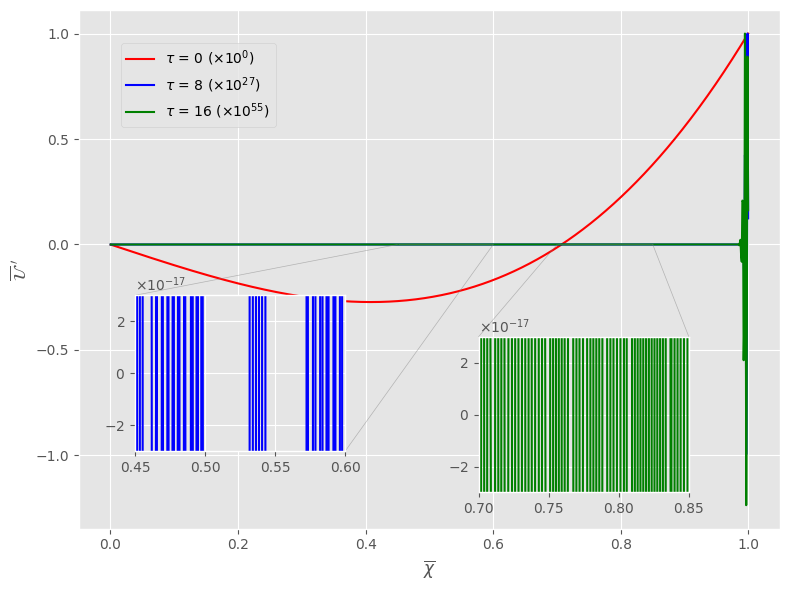

In [ ]:
# Visualize the simulation at fixed time steps
x = storage[0].grid.axes_coords[0]
y = [storage[t].data for t in viz_time]
My = [int(np.log10(y_i.max() + 1)) for y_i in y]

y = [y_i / y_i.max() for y_i in y]

fig, ax = plt.subplots(figsize=(8, 6))
C = ['r-', 'b-', 'g-', 'k-']
for i, y_i in enumerate(y):
    ax.plot(x,
            y_i,
            C[i],
            label=rf'$\tau$ = {viz_time[i]} ($\times 10^{{{My[i]:d}}}$)')
ax.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))
ax.set_xlabel(r'$\overline{\chi}$')
ax.set_ylabel(r'$\overline{\mathcal{U}}^{~\prime}$')

# Create an inset axis to zoom around some values
ax_inset_1 = ax.inset_axes([0.08, 0.15, 0.3, 0.3])
ax_inset_1.plot(x,
                y[1],
                C[1],
                label=rf'$\tau$ = {viz_time[1]} ($\times 10^{{{My[1]:d}}}$)')
ax_inset_1.set_xlim([0.45, 0.60])
ax_inset_1.set_ylim([-3e-17, 3e-17])
ax_inset_1.ticklabel_format(axis='y',
                            style='sci',
                            scilimits=(0, 0),
                            useMathText=True)
ax_inset_1.set_xticks([0.45, 0.50, 0.55, 0.60])
ax_inset_1.set_yticks([-2e-17, 0, 2e-17])
ax.indicate_inset_zoom(ax_inset_1)

ax_inset_2 = ax.inset_axes([0.57, 0.07, 0.3, 0.3])
ax_inset_2.plot(x,
                y[2],
                C[2],
                label=rf'$\tau$ = {viz_time[2]} ($\times 10^{{{My[2]:d}}}$)')
ax_inset_2.set_xlim([0.70, 0.85])
ax_inset_2.set_ylim([-3e-17, 3e-17])
ax_inset_2.ticklabel_format(axis='y',
                            style='sci',
                            scilimits=(0, 0),
                            useMathText=True)
ax_inset_2.set_xticks([0.70, 0.75, 0.80, 0.85])
ax_inset_2.set_yticks([-2e-17, 0, 2e-17])
ax.indicate_inset_zoom(ax_inset_2)

fig.tight_layout()
fig.savefig(output_dir / f'full_values_{output_file}.pdf', dpi=300)
plt.show()
plt.close(fig)

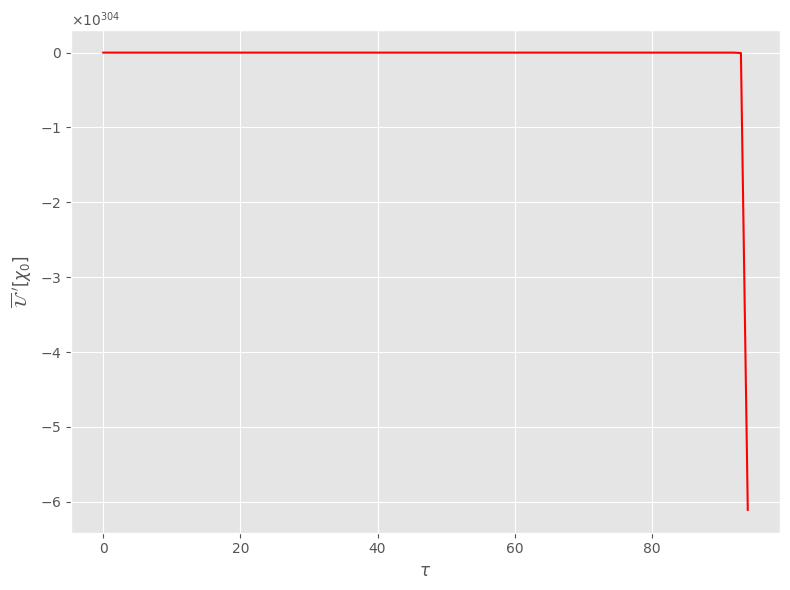

In [ ]:
# Display the evolution of the field in 0
chi = 0.5
t = []
y = []

fig, ax = plt.subplots(figsize=(8, 6))
for time, field in storage.items():

    x = field.grid.axes_coords[0]
    idx = (x >= chi).argmax()
    t.append(time)
    y.append(field.data[idx])

ax.plot(t, y, 'r-')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(rf'$\overline{{\mathcal{{U}}}}^{{~\prime}}[{{\chi_0}}]$')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)

fig.tight_layout()
fig.savefig(output_dir / f'evolution_{output_file}.pdf', dpi=300)
plt.show()
plt.close(fig)

In [ ]:
# Visualize the simulation results
Video(output_dir / f'movie_{output_file}.mp4')